# DeepDream

## 参考: https://tensorflow.classcat.com/2019/11/21/tf20-tutorials-generative-deepdream/

In [ ]:
!python --version
!nvcc --version

Python 3.7.15
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib as mpl
 
from IPython.display import clear_output
from matplotlib import pyplot as plt
from keras.preprocessing import image
from pathlib import Path

print(keras.__version__)

2.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ファイルのマウント
  * 取り急ぎ、夢として見る画像は[test.jpg]にしている

In [ ]:
directories = {'pira': 'test_data_pira-lily', 'tsukureru': 'test_data_tsukureru', 'himmel': 'test_data_himmel'}
in_directory = 'test_data'
dream_ify = 'AG_pira-1590692984395567105-20221110_220855-img2.jpg'
image_path_str = '/content/gdrive/MyDrive/Colab' + ' ' + 'Notebooks/test_data/' + directories['pira'] + '/' + in_directory
dream_image_original = Path(image_path_str, dream_ify)

# kerasの形式に変換する？
keras_image =  tf.keras.preprocessing.image.load_img(dream_image_original, target_size=None)

# 画像の変換

In [ ]:
# Display an image
def show(image):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(image)
  plt.show()
 

In [ ]:
def deprocess(image):
  # Noarmalize Image
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

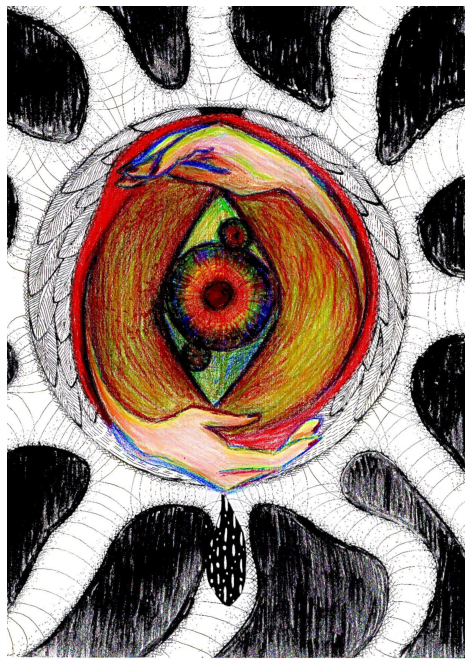

In [ ]:
keras_image_for_np = np.array(keras_image)
 
show(keras_image_for_np)

# 事前訓練されたモデルをダウンロードする。
　* `InceptionV3`を使用する

# ここらへんから理解していない

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 4s 0us/step


InceptionV3 アーキテクチャは非常に巨大です (モデル・アーキテクチャのグラフについては TensorFlow の 研究 repo を見てください)。DeepDream については、関心のある層は畳み込みが結合されてるところのものです。InceptionV3 では 11 のこれらの層があります、’mixed0′ から ‘mixed10’ と名前付けられています。異なる層の使用は異なる夢のような画像という結果になります。より深い層は (目や顔のような) 高位な特徴に対応する一方で、早い層は (エッジ、形状とテクスチャーのような) 単純な特徴に対応します。下で選択された層で自由に実験してください、しかしより深い層はその上で訓練するためにより長い時間かかることに留意してください、何故ならば勾配計算がより深いためです。

TODO: 眠いので、写経だけしてあとで理解をする

In [ ]:

# mixes3, mixes5で試す
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]
 
# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(image, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  image_batch = tf.expand_dims(image, axis=0)
  layer_activations = model(image_batch)
 
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
 
  return  tf.reduce_sum(losses)

In [ ]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `image`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(image)
      loss = calc_loss(image, model)
 
    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, image)
 
    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8
     
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    image = image + gradients*step_size
    image = tf.clip_by_value(image, -1, 1)
 
    return loss, image

In [ ]:
def run_deep_dream_simple(model, image, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  image = tf.keras.applications.inception_v3.preprocess_input(image)
 
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
     
    if step % 100 == 0:
      clear_output(wait=True)
      show(deprocess(image))
      print ("Step {}, loss {}".format(step, loss))
 
 
  result = deprocess(image)
  clear_output(wait=True)
  show(result)
 
  return result

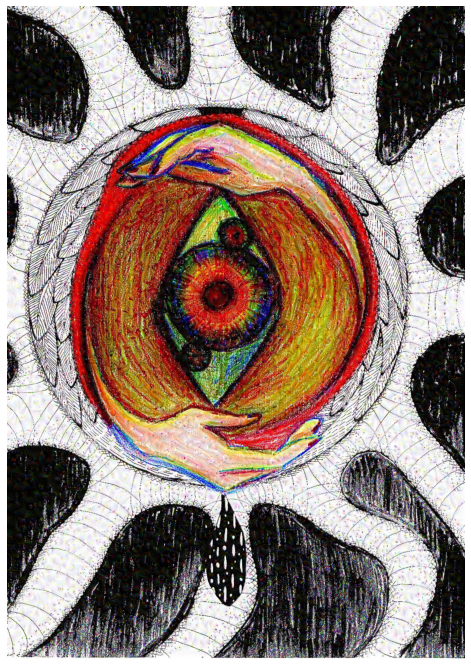

Step 600, loss 1.7851883172988892


In [ ]:
dream_image = run_deep_dream_simple(model=dream_model, image=keras_image_for_np, steps=800, step_size=0.001)

# オクターブで引き上げる
## 勾配上昇アプローチを遂行してから画像のサイズを増やす


In [ ]:
OCTAVE_SCALE = 1.3
 
image = tf.constant(np.array(keras_image_for_np))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)
 
for n in range(3):
  new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)
 
  image = tf.image.resize(image, new_shape).numpy()
 
  image = run_deep_dream_simple(model=dream_model, img=image, steps=200, step_size=0.001)
 
clear_output(wait=True)
show(image)

# タイルでスケールアップする
* 画像がサイズ的に増加するために、勾配計算を遂行するために必要な時間とメモリです。上のオクターブ実装は非常に巨大な画像や多くのオクターブ上では動作しません。この問題を回避するために画像をタイルに分割して各タイルのための勾配を計算することができます。

In [ ]:
def random_roll(image, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1]
  img_rolled = tf.roll(tf.roll(image, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [ ]:
shift_down, shift_right, img_rolled = random_roll(np.array(keras_image_for_np), 512)
show(img_rolled)

ここに先に定義された deepdream 関数の tiled された同値がある

In [ ]:
@tf.function
def get_tiled_gradients(model, image, tile_size=512):
  shift_down, shift_right, image_rolled = random_roll(image, tile_size)
 
  # Initialize the image gradients to zero.
  gradients = tf.zeros_like(image_rolled)
 
  for x in tf.range(0, image_rolled.shape[0], tile_size):
    for y in tf.range(0, image_rolled.shape[1], tile_size):
      # Calculate the gradients for this tile.
      with tf.GradientTape() as tape:
        # This needs gradients relative to `image_rolled`.
        # `GradientTape` only watches `tf.Variable`s by default.
        tape.watch(image_rolled)
 
        # Extract a tile out of the image.
        image_tile = image_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(image_tile, model)
 
      # Update the image gradients for this tile.
      gradients = gradients + tape.gradient(loss, image_rolled)
 
  # Undo the random shift applied to the image and its gradients.
  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
 
  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8
 
  return gradients

# これをまとめるとスケーラブルで、octave-aware な deepdream 実装を与えます

In [ ]:
def run_deep_dream_with_octaves(model, image, steps_per_octave=100, step_size=0.01,
                                num_octaves=3, octave_scale=1.3):
  image = tf.keras.preprocessing.image.img_to_array(image)
  image = tf.keras.applications.inception_v3.preprocess_input(image)
 
  for octave in range(num_octaves):
    # Scale the image based on the octave
    if octave>0:
      new_size = tf.cast(tf.convert_to_tensor(image.shape[:2]), tf.float32)*octave_scale
      image = tf.image.resize(image, tf.cast(new_size, tf.int32))
 
    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(model, image)
      image = image + gradients*step_size
      image = tf.clip_by_value(image, -1, 1)
 
      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(image))
        print ("Octave {}, Step {}".format(octave, step))
     
  clear_output(wait=True)
  result = deprocess(image)
  show(result)
 
  return result

In [ ]:
dream_image = run_deep_dream_with_octaves(model=dream_model, img=keras_image_for_np, step_size=0.01)
 
clear_output()
show(keras_image_for_np)
show(dream_image)